In [2]:
!pip3 install rpy2

  Using cached cffi-1.16.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata (1.5 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
  Using cached MarkupSafe-2.1.5-cp311-cp311-macosx_10_9_x86_64.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.9/299.9 kB 5.9 MB/s eta 0:00:00:00:01
Using cached cffi-1.16.0-cp311-cp311-macosx_10_9_x86_64.whl (182 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
Using cached MarkupSafe-2.1.5-cp311-cp311-macosx_10_9_x86_64.whl (14 kB)
Using cached pycparser-2.22-py3-none-any.whl (117 kB)


In [54]:
# R libraries
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Data wrangling
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
def read_rda(path, r_df_name):

    # Activate the automatic conversion of R objects to pandas objects
    pandas2ri.activate()

    # Path to your .rda file
    rda_file_path = path

    # Load the .rda file
    robjects.r['load'](rda_file_path)

    # Assuming the .rda file contains a single data frame named 'df_name'
    df_name = r_df_name

    # Retrieve the data frame from R environment
    r_dataframe = robjects.r[df_name]

    # Convert R data frame to pandas DataFrame
    try:
        pandas_dataframe = pandas2ri.rpy2py(r_dataframe)
    except TypeError as e:
        print("TypeError encountered:", e)
        # Attempt a manual conversion or inspect data structure
        pandas_dataframe = pd.DataFrame({key: list(val) for key, val in r_dataframe.items()})

    return pandas_dataframe

In [42]:
def harmonize_df(df, city_name, main_street_name):
    
    df.drop(columns = ['LONGITUDE', 'LATITUDE', 'geometry'], inplace = True)
    df['CITY'] = city_name
    main_street_dist = 'DISTANCE_TO_' + main_street_name
    df.rename(columns = {main_street_dist:'DISTANCE_TO_MAIN'}, inplace = True)

    return df

## Read and process data

In [43]:
df_mad = read_rda('../data-raw/Madrid_Sale.RData', 'Madrid_Sale')
df_mad = harmonize_df(df_mad, 'MADRID', 'CASTELLANA')

df_bcn = read_rda('../data-raw/Barcelona_Sale.RData', 'Barcelona_Sale')
df_bcn = harmonize_df(df_bcn, 'BARCELONA', 'DIAGONAL')

df_val = read_rda('../data-raw/Valencia_Sale.RData', 'Valencia_Sale')
df_val = harmonize_df(df_val, 'VALENCIA', 'BLASCO')

assert df_val.columns.all() == df_bcn.columns.all() == df_mad.columns.all()

TypeError encountered: 'NULLType' object is not iterable
TypeError encountered: 'NULLType' object is not iterable
TypeError encountered: 'NULLType' object is not iterable


In [85]:
df = pd.concat([df_val, df_bcn, df_mad], axis = 0)
df.head()

,ASSETID,PERIOD,PRICE,UNITPRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,...,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_MAIN,CITY
0,27088,201812,111000.0,1480.000000,75,2,1,1,1,1,...,7,35,6,0,0,1,3.759093,0.756517,3.373132,VALENCIA
1,6306,201812,169000.0,1320.312500,128,4,2,0,1,1,...,7,56,5,0,0,1,2.073773,0.370680,0.540594,VALENCIA
2,24353,201812,162000.0,1883.720930,86,2,1,0,1,1,...,6,20,4,0,0,1,2.099641,0.038560,0.719203,VALENCIA
3,8874,201812,199000.0,1792.792793,111,4,2,0,1,0,...,8,25,5,0,0,1,2.120917,0.524827,0.915379,VALENCIA
4,24135,201812,73000.0,1303.571429,56,3,1,1,1,0,...,6,20,8,0,0,1,3.087950,1.129985,2.009535,VALENCIA


## Visualise

Text(0.5, 1.0, 'Madrid')

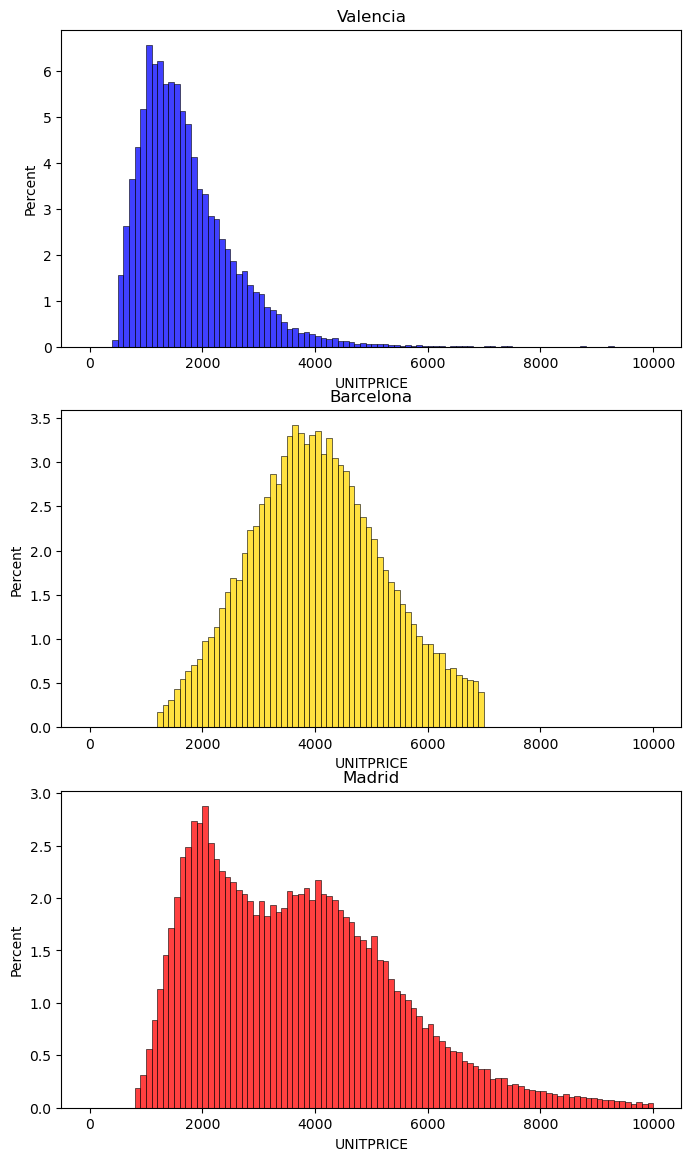

In [81]:
# Histograms

fig, ax = plt.subplots(3, 1, figsize = (8,14))

sns.histplot(df_val['UNITPRICE'], ax=ax[0], color = 'blue', stat = 'percent', binrange = (0,10000), binwidth=100)
ax[0].set_title('Valencia')
sns.histplot(df_bcn['UNITPRICE'], ax=ax[1], color = 'gold', stat = 'percent', binrange = (0,10000), binwidth=100)
ax[1].set_title('Barcelona')
sns.histplot(df_mad['UNITPRICE'], ax=ax[2], color = 'red', stat = 'percent', binrange = (0,10000), binwidth=100)
ax[2].set_title('Madrid')


<Axes: xlabel='ROOMNUMBER', ylabel='Count'>

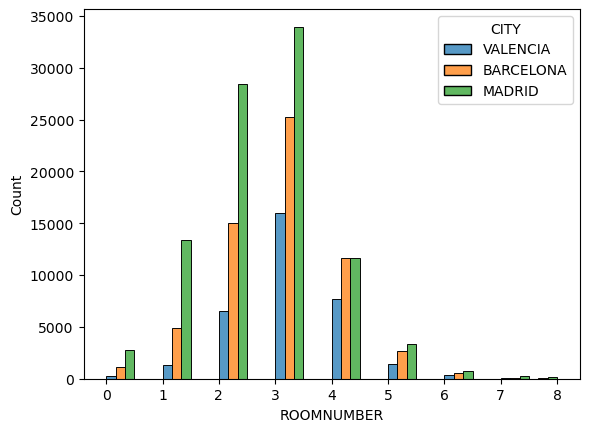

In [120]:
sns.histplot(data=df, x='ROOMNUMBER', hue='CITY', binrange=(0,8), binwidth=0.5, multiple = 'dodge')

<Axes: xlabel='CONSTRUCTEDAREA', ylabel='Count'>

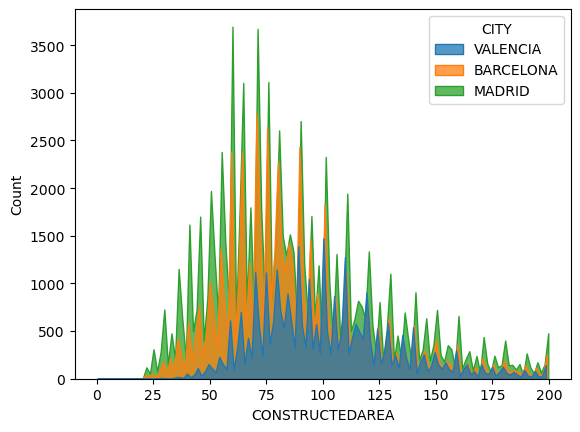

In [139]:
sns.histplot(data=df, x='CONSTRUCTEDAREA', hue='CITY', multiple = 'dodge', element = 'poly', binrange=(0,200))

In [75]:
df_val.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA',
       'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE', 'HASLIFT',
       'HASAIRCONDITIONING', 'AMENITYID', 'HASPARKINGSPACE',
       'ISPARKINGSPACEINCLUDEDINPRICE', 'PARKINGSPACEPRICE',
       'HASNORTHORIENTATION', 'HASSOUTHORIENTATION', 'HASEASTORIENTATION',
       'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL',
       'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
       'CONSTRUCTIONYEAR', 'FLOORCLEAN', 'FLATLOCATIONID',
       'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
       'CADASTRALQUALITYID', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_MAIN',
       'CITY'],
      dtype='object')

In [132]:
help(sns.histplot)

Help on function histplot in module seaborn.distributions:

histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)
    Plot univariate or bivariate histograms to show distributions of datasets.
    
    A histogram is a classic visualization tool that represents the distribution
    of one or more variables by counting the number of observations that fall within
    discrete bins.
    
    This function can normalize the statistic computed within each bin to estimate
    frequency, density or probability mass, and it can add a smooth curve obtained
    using a kernel density estimate